In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
data = 'https://raw.githubusercontent.com/jubins/IDS-Project-Bank-Marketing-Analysis/master/bank.csv'
df = pd.read_csv(data, sep=';')
bank_df = df.copy()
print(df.shape)
df.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Exploratory Analysis of feature importance among target and variables

#### Identifying Imbalance and Missingness in data

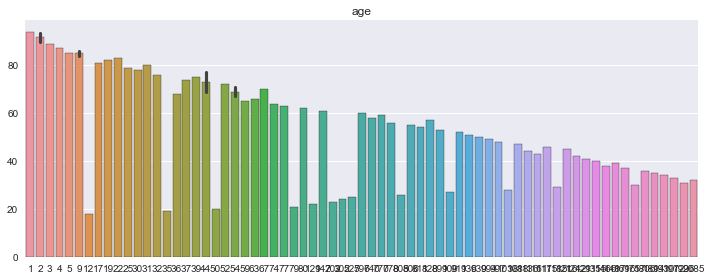

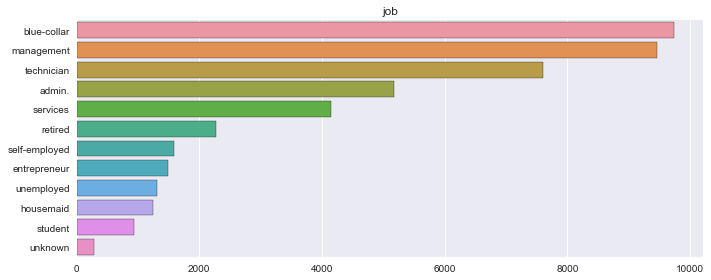

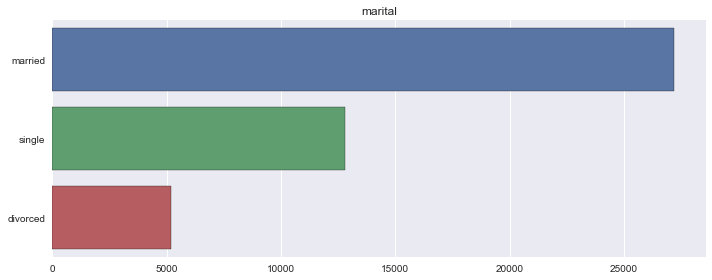

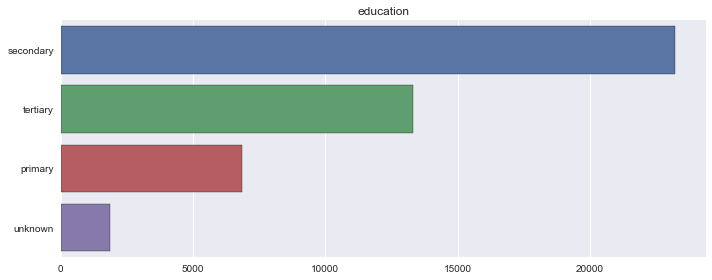

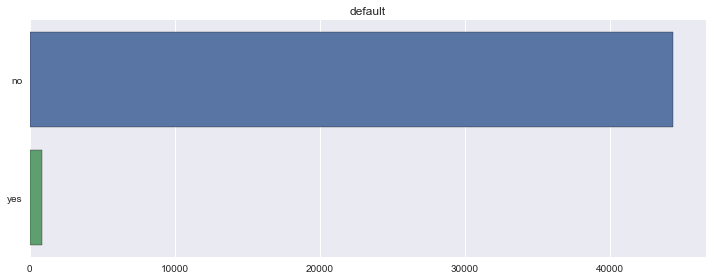

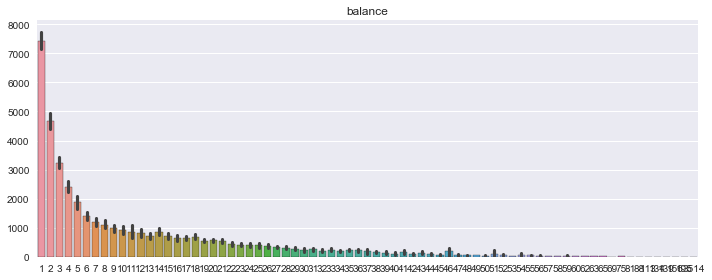

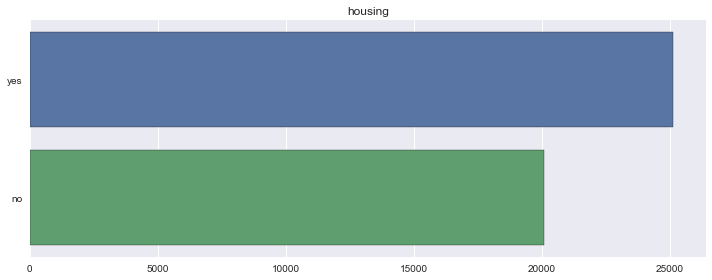

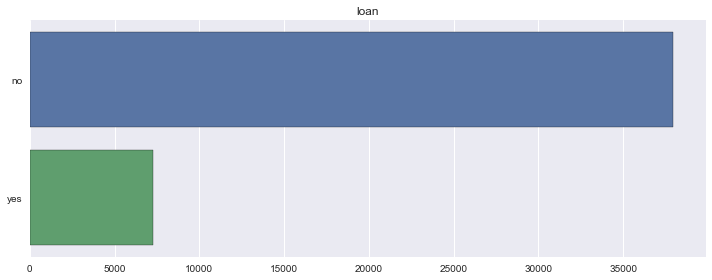

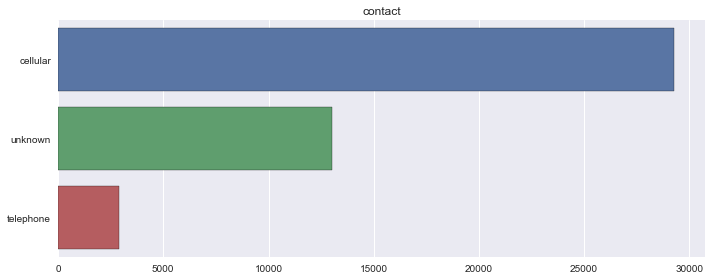

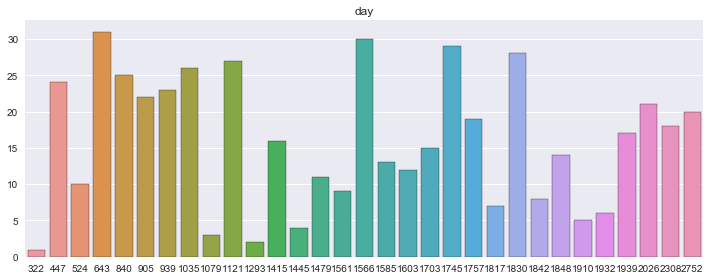

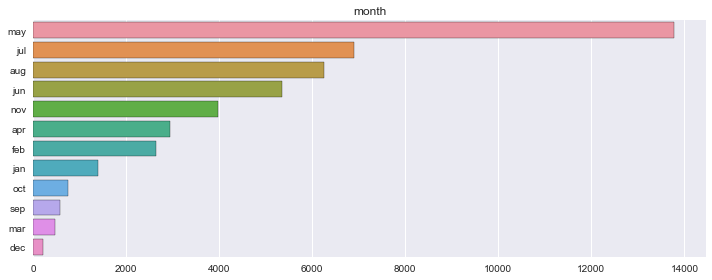

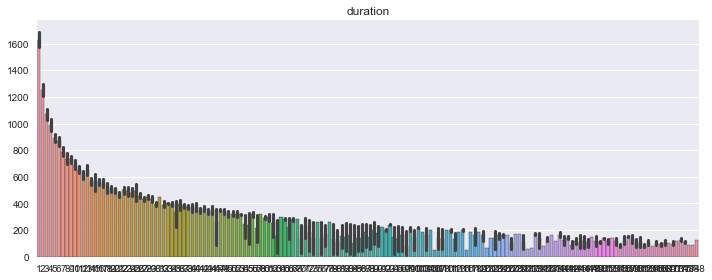

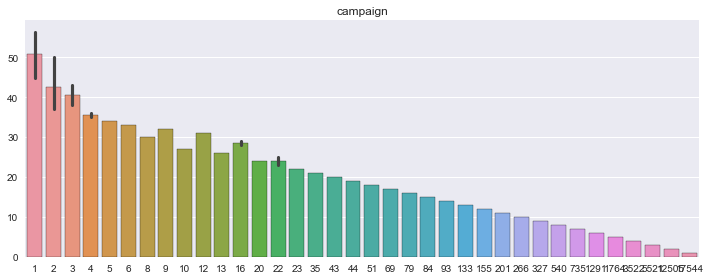

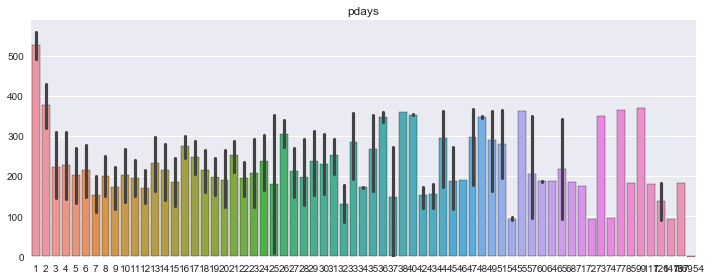

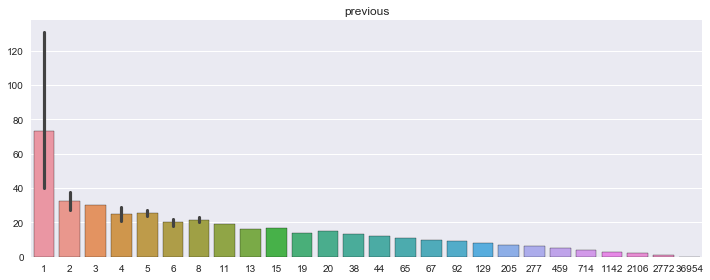

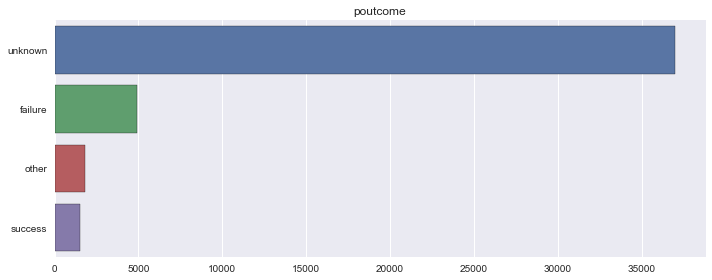

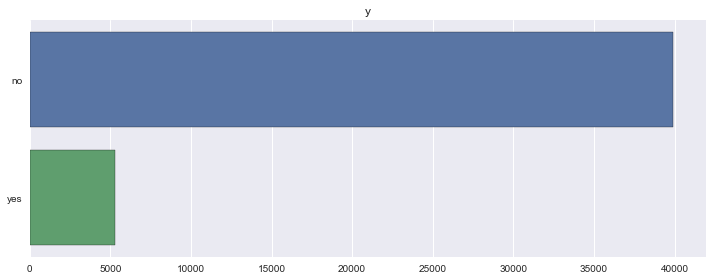

In [4]:
for col in df.columns:
    plt.figure(figsize=(10,4))
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()

Imbalanced Data:
**Default, Loan:** has 80% data as 'No' and 20% as 'Yes', this is significant imbalance.

Unknown Data:
**Job, Education, Contact, Poutcome** have some data which is 'unknown'.


#### Performing Chi-Square Test

Index(['age_vec', 'job_vec', 'marital_vec', 'education_vec', 'default_vec',
       'balance_vec', 'housing_vec', 'loan_vec', 'contact_vec', 'day_vec',
       'month_vec', 'duration_vec', 'campaign_vec', 'pdays_vec',
       'previous_vec', 'poutcome_vec', 'y_vec'],
      dtype='object')
['0.0000000000', '0.0000000000', '1.0000000000', '1.0000000000', '0.9967479588', '0.0000000000', '1.0000000000', '1.0000000000', '1.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '1.0000000000']


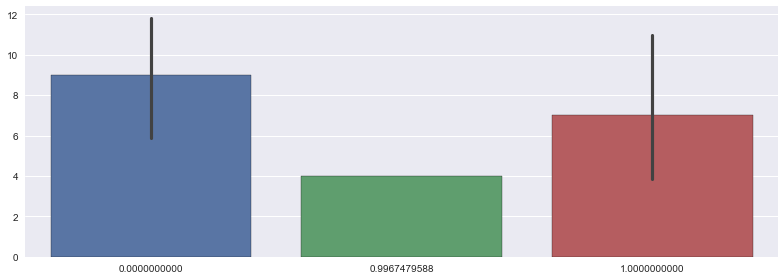

In [5]:
#Function converting column values into numerical vectors
def column_vectorizer(df, column_name):
    return df[column_name].apply(lambda x: column_dict(df, column_name)[x])

def column_dict(df, column_name):
    column_vector = {}
    for i, item in enumerate(df[column_name].unique()):
        column_vector[item] = i
    return column_vector

for col in df.columns:
    df[col+'_vec'] = column_vectorizer(df, col)
    
#Performing Chi-Square Test
chisquare_test = stats.chisquare(np.array(df.iloc[:,17:]))
chi_sq = []
for i in chisquare_test[1]:
    chi_sq.append("%.10f" %i)

print(df.iloc[:,17:].columns)
print(chi_sq)

plt.figure(figsize=(11,4))
sns.barplot(chi_sq, [i for i in range(17)])
plt.tight_layout()

Result: We see that the p-value is greater than 0.01 on Marital, Education, Default, Housing, Loan, Contact, this suggests that these features are dependent on Target and we simply cannot ignore them. 

So we will perform Imputation in below format:
1. Add 50% of 'Yes' data from Loan and Default to 'No'. Because we think 'No' is added because the information was not collected.
2. Consider 'Unkowns' in Education, Job columns as a new feature.
3. Keep Housing, Marital and Contact as it is.

## Performing Imputation

##### 0. Spearman

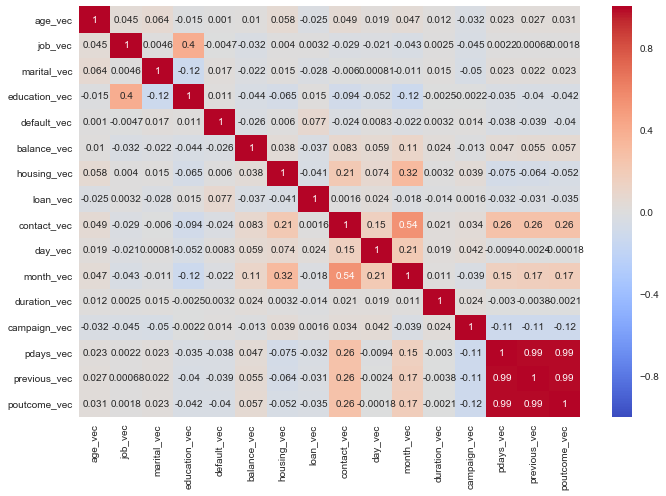

In [6]:
plt.figure(figsize=(10,7))
sns.heatmap(df.iloc[:,17:33].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.tight_layout()

Result:
1. Loan and Default are most negatively correlated to Balance. So we will use Balance for our comparison.
2. Poutcome has most negative correlation with Contact.
3. Pdays has most negative correlation with Contact.

##### 1. Loan Column

(45211, 34)


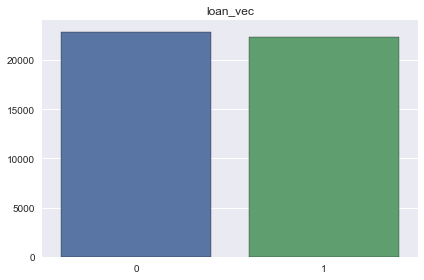

In [7]:
#We have seen 358 of 691 are likely to take a Loan when Balance<300,
#so we will replace those with Loan='No' keeping $300 thrshold

df[(df.loan_vec==1) & (df.balance<300)].shape
condition = (df.loan_vec==0) & (df.balance<300)
balance_df = df[condition]
balance_df.loan_vec.replace(0,1, inplace=True)
df = pd.concat([balance_df, df[~condition]])
print(df.shape)
col='loan_vec'
sns.barplot(df[col].value_counts().index, df[col].value_counts().values)
plt.title(col)
plt.tight_layout()
plt.show()

##### 2. Default Column

(45211, 34)


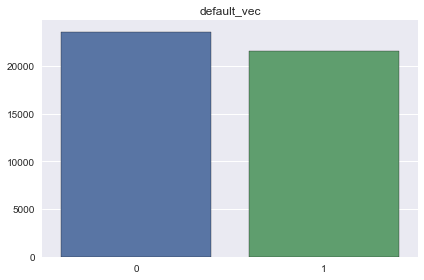

In [8]:
#We have seen that 66 of 76 people default when Balance<50, while 72 of 76 default when Balance<400
#So we will take $400 as the threshold limit
condition = (df.default_vec==0) & (df.balance<400)
balance_df = df[condition]
balance_df.default_vec.replace(0,1, inplace=True)
df = pd.concat([balance_df, df[~condition]])
print(df.shape)
col='default_vec'
sns.barplot(df[col].value_counts().index, df[col].value_counts().values)
plt.title(col)
plt.tight_layout()
plt.show()

##### 3. Poutcome Column

In [9]:
#We see that where ever poutcome='success', the contact='cellphone'. However, same thing is for 'failure'.
df[df.poutcome=='success'].contact.value_counts()

cellular     1385
telephone     114
unknown        12
Name: contact, dtype: int64

##### 4. Pdays Column

(45211, 34)


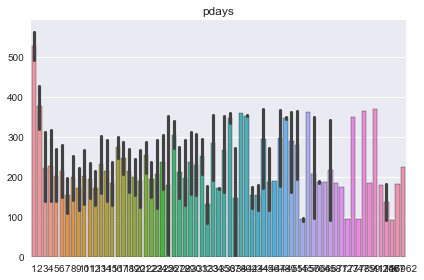

In [10]:
#Eventhough we see correlation with Contact, we will replace the NaN in pdays with mean of values in pdays.
condition = (df.pdays==-1)
balance_df = df[condition]
pdays_mean = np.floor(np.mean(df[~condition].pdays))
balance_df.pdays.replace(-1,pdays_mean, inplace=True)
df = pd.concat([balance_df, df[~condition]])
print(df.shape)
col='pdays'
sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
plt.title(col)
plt.tight_layout()
plt.show()

## Peforming data modeling

In [11]:
bank_df = df.copy()
features = ['job_vec','marital_vec','education_vec','default_vec','loan_vec','duration_vec',
            'contact_vec','campaign_vec', 'pdays', 'y_vec']
X = bank_df[features].iloc[:,:-1]
y = bank_df[features].iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

bank_df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,...,loan_vec,contact_vec,day_vec,month_vec,duration_vec,campaign_vec,pdays_vec,previous_vec,poutcome_vec,y_vec
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,1,0,0,0,1,0,0,0,0,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,1,0,0,0,4,0,0,0,0,0
5,35,management,married,tertiary,no,231,yes,no,unknown,5,...,1,0,0,0,5,0,0,0,0,0
8,58,retired,married,primary,no,121,yes,no,unknown,5,...,1,0,0,0,8,0,0,0,0,0
10,41,admin.,divorced,secondary,no,270,yes,no,unknown,5,...,1,0,0,0,10,0,0,0,0,0


#### Implementing Decision Tree Classifier

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve, auc
dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=5, min_samples_leaf=100)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
scores = dt.predict_proba(X_test)
y_scores = []
for i in range(len(scores)):
    y_scores.append(scores[i][1])

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_scores, pos_label=1)
print("Decision Tree Accuracy: %5f" %accuracy_score(y_test, y_pred))
print("Decision Tree AUC: %5f" %auc(fpr_dt, tpr_dt))

Decision Tree Accuracy: 0.886390
Decision Tree AUC: 0.825889


#### Implementing Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.01)
lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
scores = lr.predict_proba(X_test)
y_scores = []
for i in range(len(scores)):
    y_scores.append(scores[i][1])
    
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores, pos_label=1)
print("Logistic Regression Accuracy: %5f" %accuracy_score(y_test, y_pred))
print("Logistic Regression AUC: %5f" %auc(fpr_lr, tpr_lr))

Logistic Regression Accuracy: 0.887201
Logistic Regression AUC: 0.772374


#### Implementing SVM

In [14]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', probability=True, C=0.01)
svm = svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
scores = svm.predict_proba(X_test)
y_scores = []
for i in range(len(scores)):
    y_scores.append(scores[i][1])
    
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_scores, pos_label=1)
print("SVM Accuracy: %5f" % accuracy_score(y_test, y_pred))
print("SVM AUC: %5f" %auc(fpr_svm, tpr_svm))

SVM Accuracy: 0.883589
SVM AUC: 0.740163


#### Implementing Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion='entropy', n_estimators=20)
rf = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
scores = rf.predict_proba(X_test)
y_scores = []
for i in range(len(scores)):
    y_scores.append(scores[i][1])
    
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores, pos_label=1)
print("Random Forest Accuracy: %5f" %accuracy_score(y_test, y_pred))
print("Random Forest AUC: %5f" %auc(fpr_rf,tpr_rf))

Random Forest Accuracy: 0.872530
Random Forest AUC: 0.773564


## Comparing Model Results

#### Plotting the ROC Curve

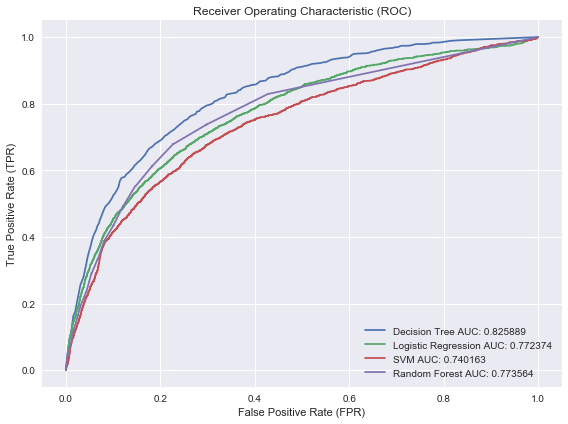

In [16]:
plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label="Decision Tree AUC: %3f" %auc(fpr_dt,tpr_dt))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression AUC: %3f" %auc(fpr_lr,tpr_lr))
plt.plot(fpr_svm, tpr_svm, label="SVM AUC: %3f" %auc(fpr_svm,tpr_svm))
plt.plot(fpr_rf, tpr_rf, label="Random Forest AUC: %3f" %auc(fpr_rf,tpr_rf))
plt.title("Receiver Operating Characteristic (ROC)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Result: We see that Decision Tree has highest AUC: 0.82 and Accuracy of 0.88. Hence we will use this as predictor to calculate feature importances.

#### Feature Importance Ranking: Most important predictors

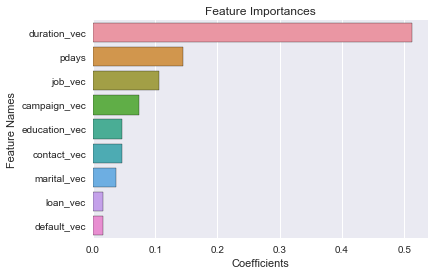

In [17]:
#Creating feature importance dictionary
feature_importance_dict = {}
for i in range(len(X.columns)):
    feature_importance_dict[X.columns[i]] = rf.feature_importances_[i]
#Sorting the dict in descending
feature_importance_dict = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
#Unpacking the tuple
feature_importance_keys,feature_importance_values = zip(*feature_importance_dict)
#Plotting the results
sns.barplot(np.array(feature_importance_values), np.array(feature_importance_keys))
plt.title('Feature Importances')
plt.xlabel('Coefficients')
plt.ylabel('Feature Names')

Results:

**Duration, Job status and pdays** are three most importat predictors of subscription. So banks should focus on them.
- Duration: How long a customer is member, he will most likely keep subscribing is he has subscription since long time.
- Job status: What is customers job status?
- PDays: How often a person is contacted regularly?

**Contact, Loan, Default** are least important factors of subscription. So banks should not focus on them.
- Contact method: Customer contacted via Cellphone, Landline does not matter.
- Loan: Whether a customer currently has a loan or not, does not matter. He will subscribe if he can.
- Default: Wheather a customer is defaulter, does not matter. He can subscribe irrespective of that.